
## 빠른 Augmentation 모듈인 Albumentation 실습
본 코드는 Albumentation의 기법 중 일부분만 다루고 있습니다.   
OpenCV를 메인으로 한 Albumentation 기법의 기본적인 구성을 이해하고 실습하는 데에 도움을 줍니다.  
많은 이미지를 다뤄야하는 딥러닝 분야와 영상처리 분야에서 주로 사용되고 있습니다.   

In [1]:
import albumentations as A
from albumentations.pytorch import transforms as A_T
from albumentations.augmentations.geometric import rotate
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from glob import glob
from IPython.display import Image as I_image

## Dataset Class 정의

In [2]:
class Dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.images = sorted(glob(os.path.join(img_dir, '*.jpeg')))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('L')

        np_image = np.array(image)
        
        if self.transform:
            transformed = self.transform(image=np_image)
            np_image = transformed["image"]

        return np_image

In [3]:
def plt_show(img_dir, transform=None):
    train_dataset = Dataset(img_dir, transform=transform)

    plt.figure(figsize=(14,14))

    for i, img in enumerate(train_dataset):
        plt.subplot(4, 4, i+1)
        plt.imshow(transforms.ToPILImage()(img), cmap='gray',)

## 원본 데이터 살펴보기
Dataset은 [[Chest X-Ray Images]](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)에서 일부 가져왔습니다.  
512 x 512 이미지이며, gray scale입니다. 

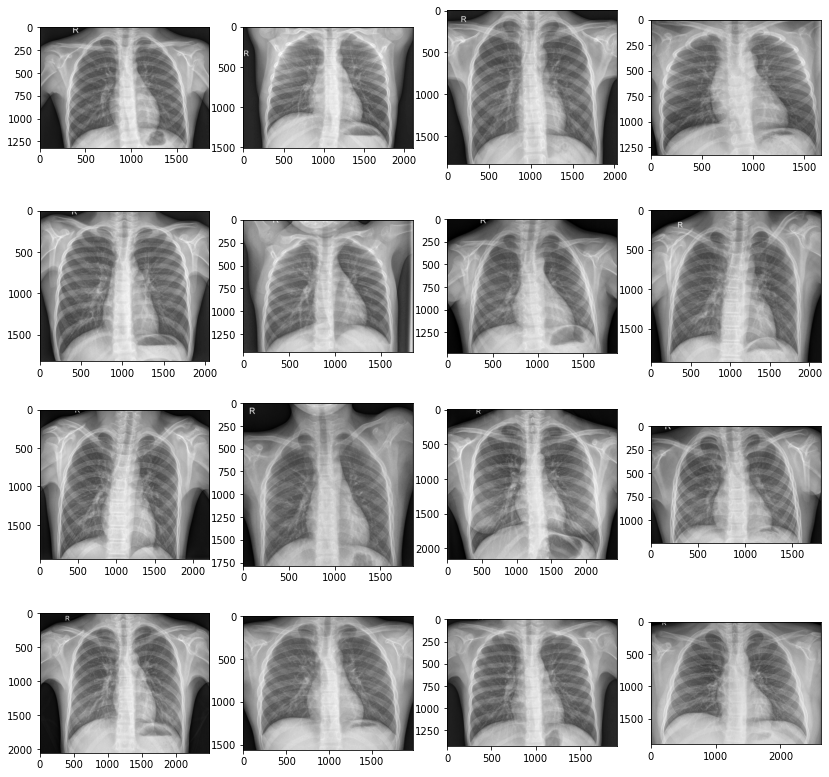

In [4]:
img_dir = os.path.join(os.getcwd(), "input", 'xray')

albumentations_transform = A.Compose([
    A_T.ToTensorV2()
])

plt_show(img_dir, albumentations_transform)


## RandomBrightnessContrast 적용하기
Contrast만 있는 것도 있지만, Conrast에 Brightness를 더한 RandomBrightnessContrast를 기법을 권장하고 있습니다.

C:\Users\pebpung\anaconda3\envs\torch\lib\site-packages\albumentations\augmentations\transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


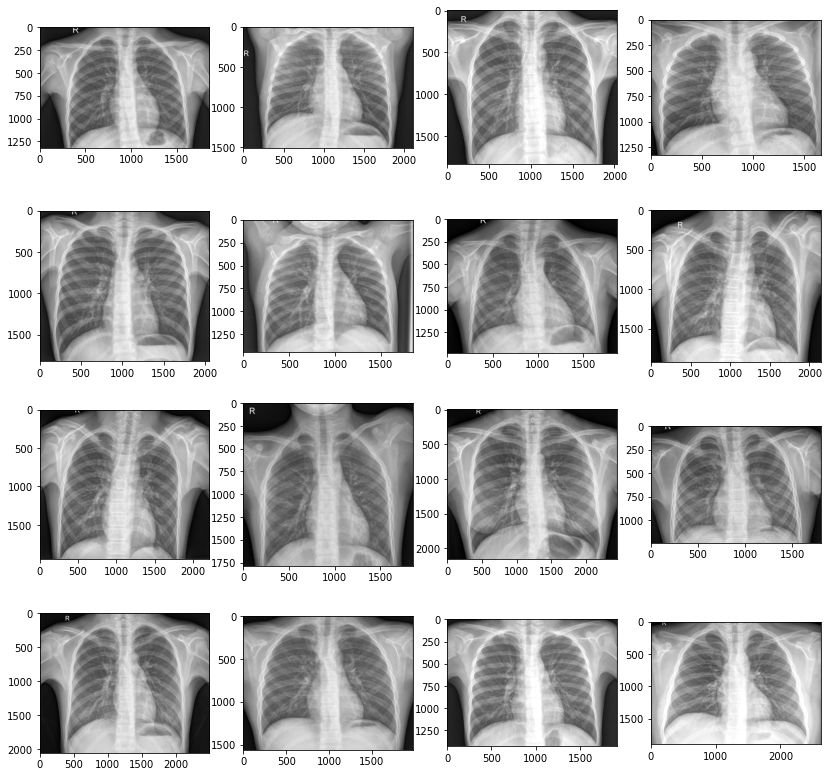

In [5]:
albumentations_transform = A.Compose([
    A.RandomContrast(p=1.0),
    A_T.ToTensorV2()
])

plt_show(img_dir, transform=albumentations_transform)

## 일반 Rotation 적용 - 15도

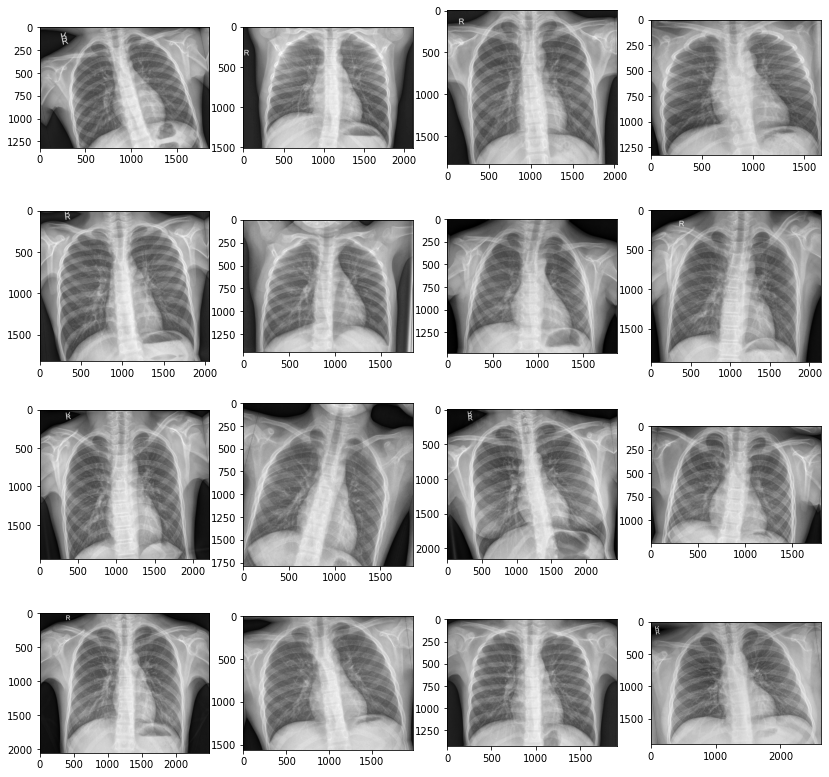

In [75]:
albumentations_transform = A.Compose([
    rotate.Rotate(limit=15, p=1.0),
    A_T.ToTensorV2()
])

plt_show(img_dir, transform=albumentations_transform)

## ShiftScaleRotate 적용 - 15도
Scaling shift를 적용하는 transform을 찾으려고 했지만,  
shift scale rotate가 동시에 적용되는 모듈 밖에 없습니다.  
그래서 rotation과 같이 고려를 해야될 것 같습니다.  

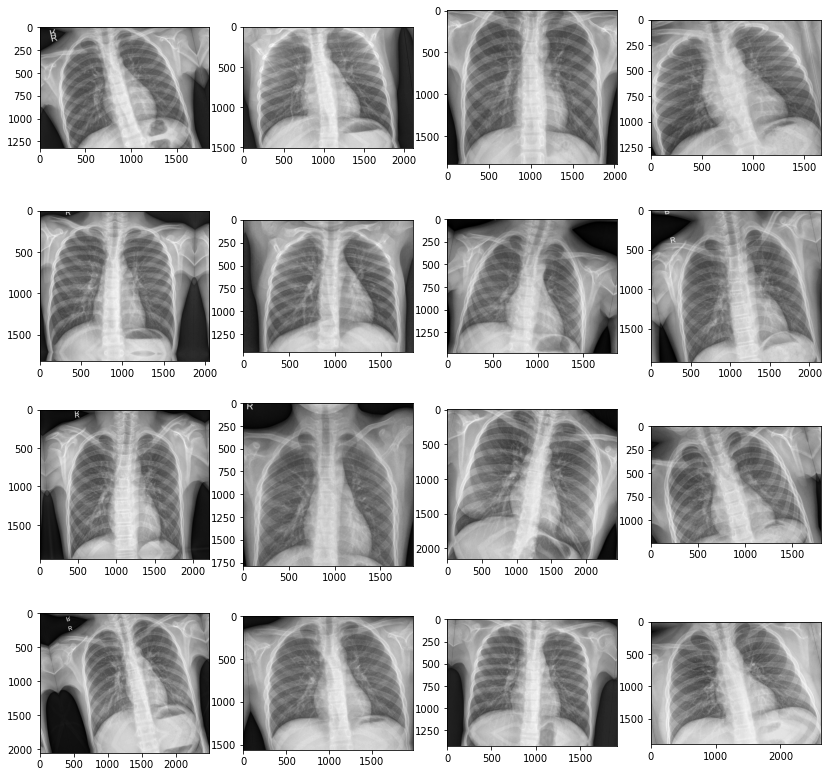

In [79]:
albumentations_transform = A.Compose([
    A.augmentations.geometric.transforms.ShiftScaleRotate(rotate_limit=15, p=1.0),
    A_T.ToTensorV2()
])

plt_show(img_dir, transform=albumentations_transform)

## Grid Distortion 적용
Grid Distortion이 적용되는 모습을 보려고 극단적인 값은 0.8을 적용했습니다.  
기존 distort_limit 값은 0.3입니다.  
Grid는 각 grid 셀에서 발생할 수 있는 왜곡을 적용 시킨 것 같습니다.


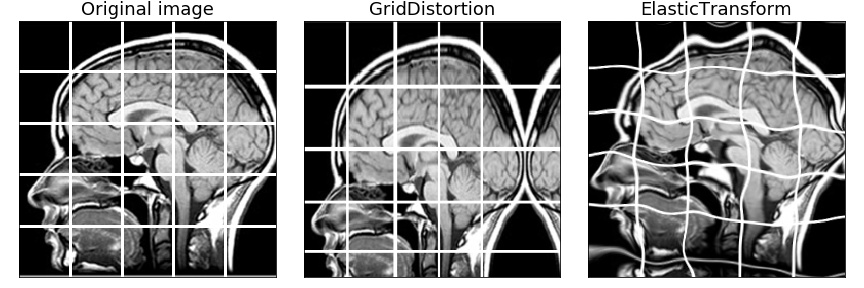

In [6]:
I_image('image/grid.png')

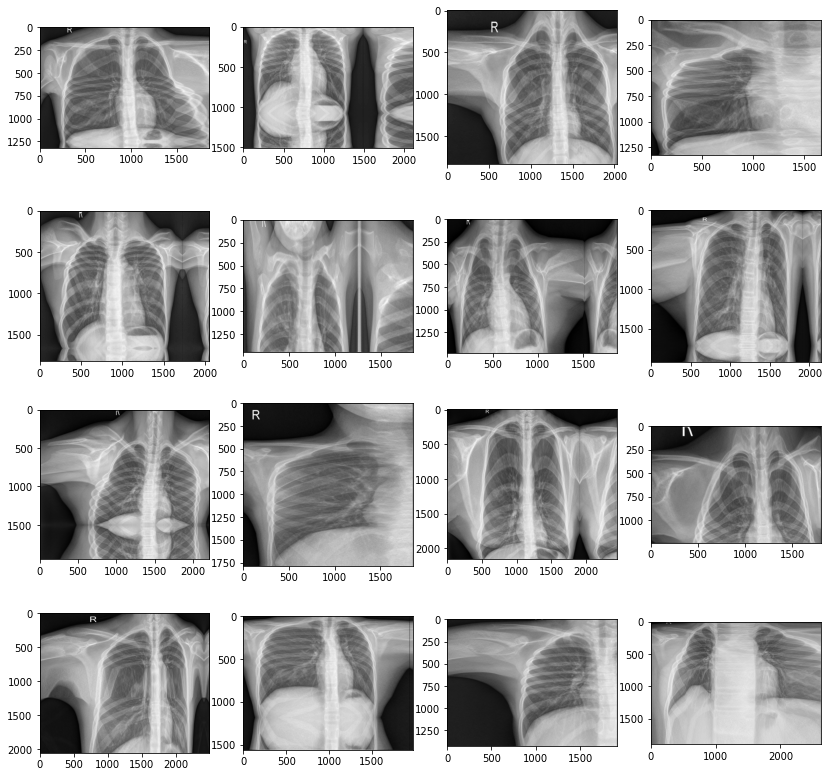

In [86]:
albumentations_transform = A.Compose([
    A.augmentations.transforms.GridDistortion(p=1.0, distort_limit=0.8),
    A_T.ToTensorV2()
])

plt_show(img_dir, transform=albumentations_transform)

## Opticla Distortion 적용
마찬가지로 Opticla Distortion이 적용되는 모습을 보려고 극단적인 값은 0.8을 적용했습니다.  
기존 distort_limit 값은 0.05입니다.  
Optical은 광학이라는 뜻으로 렌즈에서 발생하는 왜곡을 적용시키는 것 같습니다.

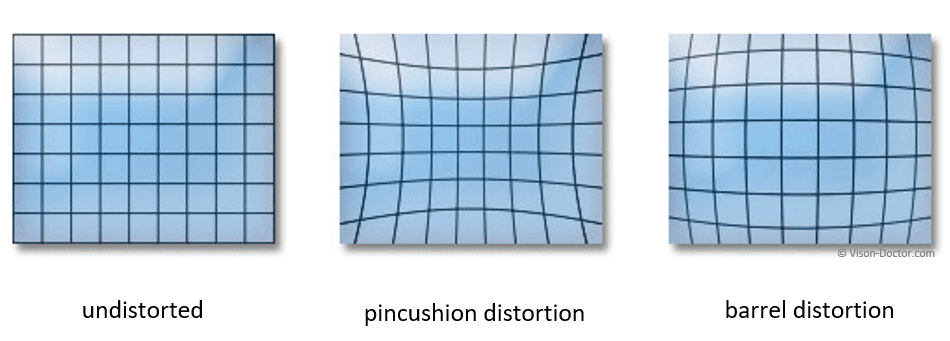

In [7]:
I_image('image/optical.png')

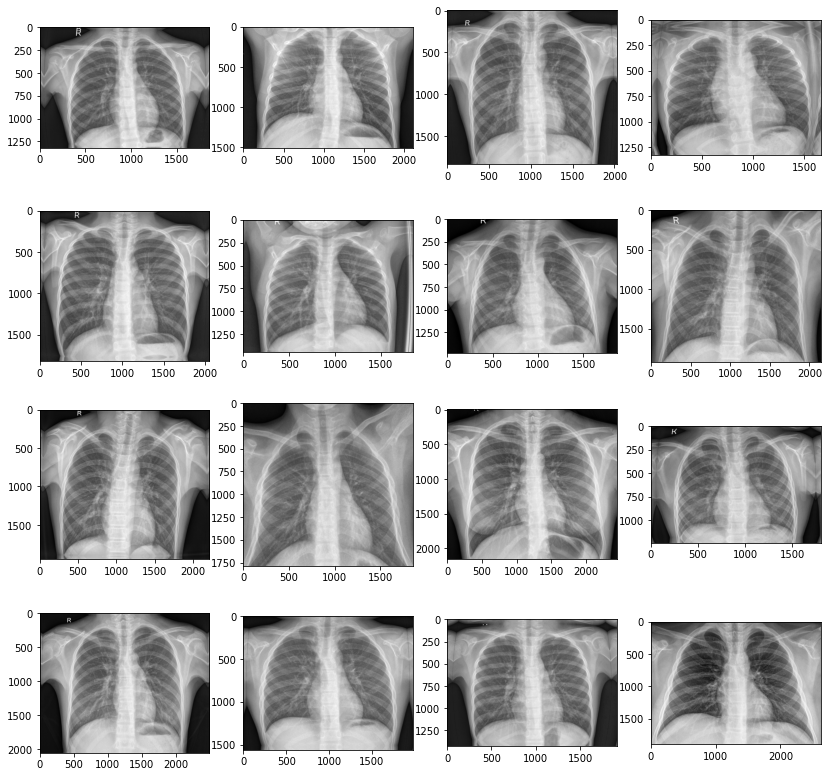

In [6]:
albumentations_transform = A.Compose([
    A.augmentations.transforms.OpticalDistortion(p=1.0, distort_limit=0.3),
    A_T.ToTensorV2()
])

plt_show(img_dir, transform=albumentations_transform)

## 의문점

1. Rotation의 limit값의 범위에 따라 학습에 많은 영향을 끼칠까?
   1. 여기서는 임의로 15도로 설정했다. 
2. Grid와 Optical의 차이점은 뭘까?
   1. Optical은 사진을 찍을때 렌즈의 굴절률을 고려한 것 같다.
3. 각 transform에 적용하는 확률은 어떻게 고려해야될까? 
   1. transoform을 적용할 때 p(확률) 파라미터를 적용하는 부분이 있다. 